In [16]:
import julia
from julia import Main
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations 
import time



Input: NLCE\_1\_#.txt stores the graphs for Order #

Outputs: NLCE\_1\_#\_data.npy stores the Ising model data for Order # as a binary file 

Change: need to save all eigentates, their corresponding energies and expectation values of quantities of interest. So that we don't need to diagonalize the Hamiltonians again if we change parameters like temperature or chemical potential etc.




In [17]:
# In this part, we read in the bond information for every 
# cluster and solve the Ising model for them.

# Maximum NLCE order
Nmax = 7

# hopping t
Main.t = 1.0

# Interaction U
Main.U = 32

# Holding "lattice constants" (multiplicities) for all clusters
# in all orders. Probably good for up to order 9. Need to check 
# what is needed exactly for the size of the second dimension.
multi = np.zeros([Nmax+1, 3500], int)

# Holding the two site numbers and optionally the bond type 
# for every bond.
site1 = np.zeros(40,int)
site2 = np.zeros(40,int)
typ   = np.zeros(40,int)

# Exchange constant and the magnetic field
#J = np.array([1, 0])
#Bfield = 0.0

# Counter for isomorphically distinct clusters
topN = 0

# load julia script
Main.include("./Hubbard.jl")
Main.include("./measurements_Hubbard.jl")

Main.name = "order=" + str(Nmax) + "_U=" + str(Main.U)

# Loop over the NLCE order
for N in range(2, Nmax+1):
  # Passing N to the julia script
  Main.N = N

  # Generate sector info for julia script
  Main.eval("sectors_info = sectors_info_gen(N=N)")
  
  # Change 1 to 2 in the line below and in the next cell 
  # to include n.n.n. bonds
  floc = "./NLCE_Clusters/"
  fbase = floc + "NLCE_1_" + str(N)
  fname =  fbase + ".txt"
  file = open(fname, 'r')

  # Skips line with order number 
  next(file)

  # Going through the file for each order line by line
  # and reading in the cluster information
  topN = int(file.readline())
  print("ORDER", N)

  EOF = False
  while EOF == False:
    # passing topN to julia script
    Main.NTOP=topN
    
    line = file.readline().split()

    # Get the number of bonds from this line, and pass it to julia script
    nB = int(line[0])
    Main.nB = nB

    # Read in the bond information, and pass it to julia script
    Main.eval("site1 = Int64[]")
    Main.eval("site2 = Int64[]")
    for b in range(nB):
      line = file.readline().split()
      site1[b] = int(eval(line[0])) 
      Main.eval(f"push!(site1, {site1[b]} + 1)")
      site2[b] = int(eval(line[1])) 
      Main.eval(f"push!(site2, {site2[b]} + 1)")
      typ[b]   = int(eval(line[2])) -1
        
    Main.eval("bonds = [[site1[i], site2[i]] for i in 1:nB]")
    # calculate eigenvalues of matrix and expectations of quantities in eigenstates
    Main.eval("quantities = E_Quants(N=N, t=t, U=U, sectors_info=sectors_info, bonds=bonds)")
    # printing calculated quantities to a file for save
    Main.eval("printing(quantities; Quant_names = quant_names, name = name, NTOP=NTOP, N=N)")
    
#---------------------------------------------------------

# Here, we take the opportunity to read in the "lattice constants" 
# (multiplicities) for each topological cluster if we have reached 
# the end of the file.

    # skipping the subgraph information for now
    sc_Num = int(file.readline())
    for s in range(sc_Num):
      next(file)
    next(file)
    
    # Checking if we have reached the end of the file
    if "Topo. # : Multp." in file.readline():
      #next(file)
      for i in range(topN+1):
        multi[N][i] = file.readline().split()[1]
      EOF = True
      file.close()
      break
    else:
      # If not yet done with clusters 
      topN += 1

ORDER 2
ORDER 3
ORDER 4
ORDER 5
ORDER 6
ORDER 7


Do the thermal average in the next block, separate from diagonalization.

In [18]:
a=np.zeros(2)
a[1]=1
a[0] = 10
np.log(a)

#Nmax=7

array([2.30258509, 0.        ])

In [19]:
# Number of temperatures
NT = 100

# Chemical potential μ
Main.μ = 0.5 * Main.U

# Choosing a logarithmic temperature grid
#Temp = np.logspace(-1,2,NT)
Temp = np.linspace(0.1,10,NT)
Main.Temps = Temp # passing Temps to julia script

# Counter for isomorphically distinct clusters
topN = 0
# Loop over the NLCE order
for N in range(2, Nmax+1):    
  # Passing N to the julia script
  Main.N = N
  # Initializing arrays and openning files
  Estore = np.zeros([1500,NT])
  Mstore = np.zeros([1500,NT])
  Esqstore = np.zeros([1500,NT])
  Msqstore = np.zeros([1500,NT])
  Nstore = np.zeros([1500,NT])
  lnZstore = np.zeros([1500,NT])

  # Change 1 to 2 in the line below and in the next cell 
  # to include n.n.n. bonds
  floc = "./NLCE_Clusters/"
  fbase = floc + "NLCE_1_" + str(N)
  fname =  fbase + ".txt"
  file = open(fname, 'r')
  fnameE = fbase + "_dataE.npy"
  fnameM = fbase + "_dataM.npy"
  fnameEsq = fbase + "_data_Esq.npy"
  fnameMsq = fbase + "_data_Msq.npy"
  fnameN = fbase + "_data_N.npy"
  fnamelnZ = fbase + "_data_lnZ.npy"
  fileE = open(fnameE, 'wb')
  fileM = open(fnameM, 'wb')
  fileEsq = open(fnameEsq, 'wb')
  fileMsq = open(fnameMsq, 'wb')
  fileN = open(fnameN, 'wb')
  filelnZ = open(fnamelnZ, 'wb')
 
  # Skips line with order number 
  next(file)

  # Going through the file for each order line by line
  # and reading in the cluster information
  topN = int(file.readline())
  print("ORDER", N)

  EOF = False
  while EOF == False:
    # passing topN to julia script
    Main.NTOP=topN
    line = file.readline().split()

    # Get the number of bonds from this line
    nB = int(line[0])
    Main.nB = nB
    
    # Skip the lines with bond information
    for b in range(nB):
      line = file.readline().split()
      #next(file)
    
# Doing and storing quantieis:
#
# 1- Average energy, <H>
# 2- Average magnetization, <M>
# 3- Average energy squared, <H^2>, and
# 4- Average magnetization squared, <M^2>
# 5- Average total number of particle <N>
    """
    numerator_E   = np.zeros(NT)
    numerator_M   = np.zeros(NT)
    numerator_Esq = np.zeros(NT)
    numerator_Msq = np.zeros(NT)
    numerator_N   = np.zeros(NT)
    denominator   = np.zeros(NT)"""
        
    # Thermal sums are done here **insert julia calculation here!!!
    start = time.time()
    Main.eval("@time quantities = reading_quantities(name= name, NTOP=NTOP, N=N)")
    Main.eval("quantities_avg = thermal_avg_loop(;Temps=Temps, μ=μ , quantities=quantities)")
    numerator_M   = Main.quantities_avg[3]
    numerator_E   = Main.quantities_avg[1]
    numerator_Esq = Main.quantities_avg[2]
    numerator_Msq = Main.quantities_avg[4]
    numerator_N   = Main.quantities_avg[5]
    denominator   = Main.quantities_avg[0]
    """
    for iT in range(NT):
        Main.T = Temp[iT]
        # calculate thermal average of quantities at iT
        Main.eval("quantities_avg = thermal_avg(;T=T, μ=μ, quantities=quantities)")
        numerator_M[iT]   = Main.quantities_avg[0,3]
        numerator_E[iT]   = Main.quantities_avg[0,1]
        numerator_Esq[iT] = Main.quantities_avg[0,2]
        numerator_Msq[iT] = Main.quantities_avg[0,4]
        numerator_N[iT]   = Main.quantities_avg[0,5]
        denominator[iT]   = Main.quantities_avg[0,0]"""
    end = time.time() 
    print(end - start)
    Estore[topN,:] = numerator_E/denominator
    Mstore[topN,:] = numerator_M/denominator
    Nstore[topN,:] = numerator_N/denominator
    lnZstore[topN,:] = np.log(denominator)
    
    # It is important to do the following subtractions at the 
    # individual cluster level to make the quantities extensive
    # for the NLCE.
    Esqstore[topN,:] = numerator_Esq/denominator - Estore[topN,:]**2
    Msqstore[topN,:] = numerator_Msq/denominator - Mstore[topN,:]**2
    
#---------------------------------------------------------

# Here, we take the opportunity to read in the "lattice constants" 
# (multiplicities) for each topological cluster if we have reached 
# the end of the file.

    # skipping the subgraph information for now
    #print(line)
    sc_Num = int(file.readline())
    for s in range(sc_Num):
      next(file)
    next(file)
    
    # Checking if we have reached the end of the file
    if "Topo. # : Multp." in file.readline():
      #next(file)
      for i in range(topN+1):
        multi[N][i] = file.readline().split()[1]
      EOF = True
      file.close()
      break
    else:
      # If not yet done with clusters 
      topN += 1

  # Saving the properties to files
  np.save(fileE, Estore)
  np.save(fileM, Mstore)
  np.save(fileEsq, Esqstore)
  np.save(fileMsq, Msqstore)
  np.save(fileN, Nstore)
  np.save(filelnZ, lnZstore)


  fileE.close()
  fileM.close()
  fileEsq.close()
  fileMsq.close()
  fileN.close()
  filelnZ.close()

ORDER 2
0.06999540328979492
ORDER 3
0.0059735774993896484
0.008989334106445312
ORDER 4
0.009999275207519531
0.010973215103149414
0.010998725891113281
0.009978771209716797
ORDER 5
0.014999866485595703


E:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in true_divide
E:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in true_divide


0.015998363494873047
0.015974998474121094
0.01434469223022461
0.01398158073425293
0.021977901458740234
0.015001058578491211
0.018975019454956055
ORDER 6
0.033998966217041016
0.03399944305419922
0.03197050094604492
0.03298592567443848
0.03897500038146973
0.20392966270446777
0.03397536277770996
0.03296017646789551
0.03800082206726074
0.03697466850280762
0.03639793395996094
0.09658527374267578
0.03698253631591797
0.03500247001647949
0.03599953651428223
0.03299355506896973
0.03215789794921875
0.13697528839111328
0.030025720596313477
0.03299903869628906
0.035022735595703125
0.033025503158569336
ORDER 7
0.16499829292297363
0.09599995613098145
0.1390235424041748
0.09100127220153809
0.1449747085571289
0.09742522239685059
0.1319117546081543
0.08800005912780762
0.13397455215454102
0.10499954223632812
0.1330246925354004
0.08997750282287598
0.13244414329528809
0.09247922897338867
0.13499784469604492
0.09042835235595703
0.13202428817749023
0.17400145530700684
0.14106297492980957
0.09100079536437988

In [20]:
# In this part, we use the ED results, the subgraph information
# and the lattice constants and construct the NLCE sums.

# This array is going to hold the contribution of clusters 
# from all orders
weights = np.zeros([6, Nmax+1, 3500, NT])

# Cluster counter; this is the same as topN from the previous part
c = 0

Main.include("./Hubbard_single_site.jl")

def NLCE():
  # O is going to hold NLCE's partial sums (sums involving clusters
  # in a particular order order) for our four properties. These are
  # Sn in Eq. (3) of https://arxiv.org/pdf/0706.3254.pdf
  # I think it needs to hold quantities for single sites at O[:,1,:]
  O = np.zeros([6,Nmax+1,NT])

  # Hard coding the contributions from the single site by hand
  # Be careful with the order of quantities in O and in julia code,
  # they might not be the same and caution is required.
  Main.Temps = Temp
  Main.eval("single_site_quants = single_site_quantities(Ts=Temps, μ=μ, U=U)")
  singleE = Main.single_site_quants[1]
  O[0,1,:] = singleE
  singleEsq = Main.single_site_quants[2]-Main.single_site_quants[1]**2
  O[2,1,:] = singleEsq
  singleM = Main.single_site_quants[3] 
  O[1,1,:] = singleM
  singleMsq = Main.single_site_quants[4]-Main.single_site_quants[3]**2
  O[3,1,:] = singleMsq
  singleN = Main.single_site_quants[5]
  O[4,1,:] = singleN
  singlelnZ = np.log(Main.single_site_quants[0])
  O[5,1,:] = singlelnZ

  # Loop over NLCE orders
  for N in range(2, Nmax+1):
    # Opening the property binary files and loading the information
    # on to arrays
    floc = "./NLCE_Clusters/"
    fbase = floc + "NLCE_1_" + str(N)
    fname =  fbase + ".txt"
    
    file = open(fname, 'r')

    fnameE = fbase + "_dataE.npy"
    fnameM = fbase + "_dataM.npy"
    fnameEsq = fbase + "_data_Esq.npy"
    fnameMsq = fbase + "_data_Msq.npy"
    fnameN = fbase + "_data_N.npy"
    fnamelnZ = fbase + "_data_lnZ.npy"
    fileE = open(fnameE, 'rb')
    fileM = open(fnameM, 'rb')
    fileEsq = open(fnameEsq, 'rb')
    fileMsq = open(fnameMsq, 'rb')
    fileN = open(fnameN, 'rb')
    filelnZ = open(fnamelnZ, 'rb')


    Estore = np.load(fileE)
    Mstore = np.load(fileM)
    Esqstore = np.load(fileEsq)
    Msqstore = np.load(fileMsq)
    Nstore = np.load(fileN)
    lnZstore = np.load(filelnZ)
    #print(Nstore[0][-1])
    #print("\n")

    # Skiping line with order number & toplogical number  
    next(file)
    
    # Tolopogy number
    c = int(file.readline())
    
    # Going through the cluster files again to read in the 
    # subcluster information
    EOF = False
    while EOF == False:

      line = file.readline().split()

      # Skiping the bond info  
      for b in range(int(line[0])):
        next(file)
        
      # Subgraph info
      sc_Num = int(file.readline())
      for sg in range(sc_Num):
        line = file.readline().split()
        subclusterSize = int(line[0])
        scMult = int(line[1])
        sb_topN = int(line[2])
        
        # In computing contributions from clusters, we first
        # subtract the subcluster weights, except for the single 
        # site subcluster
        for i in range(6):
            weights[i][N][c][:] -= weights[i][subclusterSize][sb_topN][:] * scMult
 
      # We then add the properties computed in ED and subtract the 
      # single site contributions. See https://arxiv.org/pdf/1207.3366.pdf
      # for more details.
      weights[0,N,c,:] += Estore[c,:]   - N*singleE[:]
      weights[1,N,c,:] += Mstore[c,:]   - N*singleM[:]
      weights[2,N,c,:] += Esqstore[c,:] - N*singleEsq[:]
      weights[3,N,c,:] += Msqstore[c,:] - N*singleMsq[:]
      weights[4,N,c,:] += Nstore[c,:] - N*singleN[:]
      weights[5,N,c,:] += lnZstore[c,:] - N*singlelnZ[:]

      # We are now ready to put together the partial sums, using 
      # the cluster contributions and corresponding lattice constants
      O[:,N,:] += multi[N, c]*weights[:,N, c, :]
    
      next(file)
      if "Topo. # : Multp." in file.readline():
        # It's the end of the file 
        EOF = True
        file.close()
        fileE.close()
        fileM.close()
        fileEsq.close()
        fileMsq.close()
        fileN.close()
        filelnZ.close()
        break
      else:
        c += 1
  # printing out partial sums for order 1 and 2, at NT=Ti
  Ti = -1
  for N in range(1,Nmax+1):
    print("E of order "+str(N)+" is "+str(O[0,N,Ti]))
    print("M of order "+str(N)+" is "+str(O[1,N,Ti]))
    print("Esq of order "+str(N)+" is "+str(O[2,N,Ti]))
    print("Msq of order "+str(N)+" is "+str(O[3,N,Ti]))
    print("N of order "+str(N)+" is "+str(O[4,N,Ti]))
    print("lnZ of order "+str(N)+" is "+str(O[5,N,Ti]))
    print("\n")
  return O

 
O = NLCE()

E of order 1 is 2.6877058378572083
M of order 1 is 0.0
Esq of order 1 is 78.78282414057895
Msq of order 1 is 0.2080045962834811
N of order 1 is 1.0
lnZ of order 1 is 2.477047921448284


E of order 2 is -0.14370802339967348
M of order 2 is 9.365830945206281e-18
Esq of order 2 is -0.1922007360888074
Msq of order 2 is -0.0032824752228120535
N of order 2 is 1.3322676295501878e-15
lnZ of order 2 is 0.010421551043636512


E of order 3 is -0.001563614494325627
M of order 3 is 6.643203271842594e-16
Esq of order 3 is 0.02124006532787348
Msq of order 3 is 4.258784779309632e-05
N of order 3 is -8.413485733260728e-05
lnZ of order 3 is -6.321958194277499e-06


E of order 4 is 0.00024671332080927755
M of order 4 is -1.2859849271522126e-14
Esq of order 4 is -0.0003517774047168132
Msq of order 4 is 1.496012859947271e-05
N of order 4 is -3.17678392480758e-07
lnZ of order 4 is -1.024231703539158e-05


E of order 5 is 4.400517739533427e-06
M of order 5 is 7.864648981003694e-14
Esq of order 5 is -0.000199

E:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in add


In [21]:
#---------------------------------------------------------
# In this part, we add partial sums to obtain the NLCE sums
# upto different orders. We can do it without any tricks 
# (raw sums), or using numerical resummation tricks (here
# we have implemented the Wynn algorithm, see Sec. 4 of 
# https://arxiv.org/pdf/1207.3366.pdf for more details).
# The Euler resummation algorithm is also useful and worth
# implementing.

# Doing the raw sums for NLCE
raw_O = np.zeros([6,Nmax+1,NT])
for N in range(1,Nmax+1):
    raw_O[:,N,:] = raw_O[:,N-1,:] + O[:,N,:]
# print(str(raw_O[0,4,:]))

# Doing the sums according to the Wynn algorithm for faster convergence
nwynn = 2
epsln_O = np.zeros([6,Nmax+1,NT,8])
for i in range(NT):
    for N in range(1,Nmax+1):
        epsln_O[:,N,i,0] = epsln_O[:,N-1,i,0] + O[:,N,i]

    for k in range(1,2*nwynn+1):
        for N in range(1,Nmax-k+1):
            for j in range(6):
                delta = epsln_O[j,N+1,i,k-1] - epsln_O[j,N,i,k-1]
                
                #if abs(delta/epsln_O[j,N,i,k]) > 0.0:
                if k == 1:
                    epsln_O[j,N,i,k] = 1.0/delta
                else:
                    epsln_O[j,N,i,k] = epsln_O[j,N+1,i,k-2] + 1.0/delta

nwynn *= 2

E:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars
E:\Softwares\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


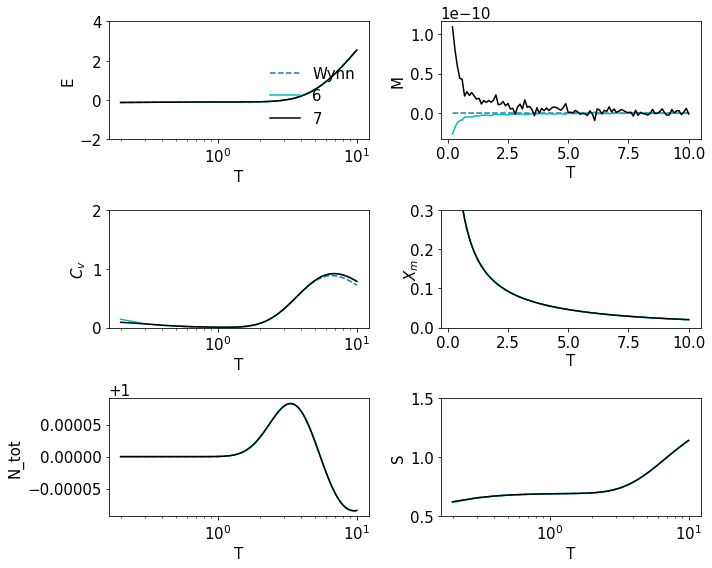

In [22]:
plt.figure(figsize=(10,8))
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15) 

colors = ['g', 'r', 'b', 'c', 'k', 'm', 'y']

# plt.rcParams['font.size']= 15

# This is to optionally skip very low temperatures data in plotting
# as they can get wild. Tlimit sets the index of the lowest 
# temperature ploted.
Tlimit = 0

# Energy
ax = plt.subplot(321)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],epsln_O[0,N,Tlimit:,nwynn],'--',label='Wynn')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[0,N,Tlimit:], colors[N-3], label='%s' % N)

plt.ylabel("E")
plt.xlabel("T")
#plt.xlim(0.1,10)
plt.ylim(-2.0,4.0)
plt.xscale('log')
ax.legend(loc='lower right', frameon=False)


# Magnetization
plt.subplot(322)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],epsln_O[1,N,Tlimit:,nwynn],'--')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[1,N,Tlimit:], colors[N-3])
plt.xlabel("T")
plt.ylabel("M")
#plt.xlim(0.5,100)
#plt.ylim(-0.1,0.1)
#plt.xscale('log')

    
# Heat capacity
# Compare this quantity with Fig. 14 of https://arxiv.org/pdf/0706.3254.pdf
plt.subplot(323)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],(epsln_O[2,N,Tlimit:,nwynn]-epsln_O[0,N,Tlimit:,nwynn]**2)/Temp[Tlimit:]**2,'--')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[2,N,Tlimit:]/Temp[Tlimit:]**2, colors[N-3])
plt.xlabel("T")
plt.ylabel(r'$C_{v}$')
#plt.xlim(0.1,10)
plt.ylim(0,2.0)
plt.xscale('log')
    
    
# Magnetic susceptibility
plt.subplot(324)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],epsln_O[3,N,Tlimit:,nwynn]/Temp[Tlimit:],'--')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[3,N,Tlimit:]/Temp[Tlimit:], colors[N-3])
#plt.xlim(0.5,100)
plt.ylim(0,0.3)
plt.xlabel("T")
plt.ylabel(r'$X_{m}$', labelpad=-11)
#plt.xscale('log')
#plt.yscale('log')



# N_tot
ax = plt.subplot(325)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],epsln_O[4,N,Tlimit:,nwynn],'--',label='Wynn')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[4,N,Tlimit:], colors[N-3], label='%s' % N)

plt.ylabel("N_tot")
plt.xlabel("T")
#plt.xlim(0.1,10)
#plt.ylim(-4.0,0)
plt.xscale('log')


# Entropy S
ax = plt.subplot(326)
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],epsln_O[5,N,Tlimit:,nwynn]+1/Temp * (epsln_O[0,N,Tlimit:,nwynn]- Main.μ * epsln_O[4,N,Tlimit:,nwynn]),'--',label='Wynn')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[5,N,Tlimit:]+1/Temp * (raw_O[0,N,Tlimit:]- Main.μ * raw_O[4,N,Tlimit:]), colors[N-3], label='%s' % N)

plt.ylabel("S")
plt.xlabel("T")
#plt.xlim(0.1,10)
plt.ylim(0.5,1.5)
plt.xscale('log')
#plt.legend(loc='lower right')
plt.tight_layout()
#plt.subplots_adjust(right = 1.1)
#plt.show()

plt.savefig('Hubbard_triangular_U='+str(Main.U)+'_order_'+str(Nmax)+'.png',format='png',dpi=600, transparent=False)

## Plotting $C_v$ only

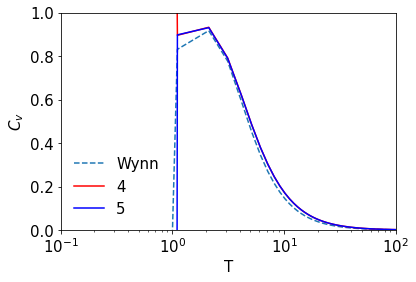

In [ ]:
Tlimit = 0
for N in range(Nmax-nwynn,Nmax-nwynn+1):
    plt.plot(Temp[Tlimit:],(epsln_O[2,N,Tlimit:,nwynn]-epsln_O[0,N,Tlimit:,nwynn]**2)/Temp[Tlimit:]**2,'--',label='Wynn')
                
for N in range(Nmax-1,Nmax+1):
    plt.plot(Temp[Tlimit:],raw_O[2,N,Tlimit:]/Temp[Tlimit:]**2, colors[N-3],label='%s' % N)
plt.xlabel("T")
plt.ylabel(r'$C_{v}$')
plt.xlim(0.1,100)
plt.ylim(0,1.0)
plt.xscale('log')

plt.legend(loc='lower left', frameon=False)

plt.savefig('Cv_order_9'+'.png',format='png',dpi=600, transparent=True)

In [ ]:
# print the weights of graphs for 1 and 2th orders
# partial sums of each order 2,3,4,5 (high T)
# entropy calculation lnZ+β(E-μN)
